#  GTA (1850-2015) and AMO (1857-2015)

For filtering (Kalman filter and fixed interval smoothing) I will use toolbok [E4](https://www.ucm.es/e-4/):

In [1]:
clear
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


It is also necessary to load the control toolbox

In [2]:
pkg load control

We load `gta.data` that I have download from [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

In [3]:
load gta.data

The fourteenth column of `gta` matrix contains the annual data for the years 1850--2015. For convenience I define the variable `y` with the annual data (i.e. periodicity one: `p=1`).

In [4]:
y = gta(:,14);
p = 1;

Professor Peter C. Young has kindly sent me the following data sets. 

In [5]:
load data4Marcos.mat % GTA and TRF (1857-2015)

In [6]:
load amo4Marcos.mat  % AMO (1857-2015)

In [7]:
%%plot gnuplot

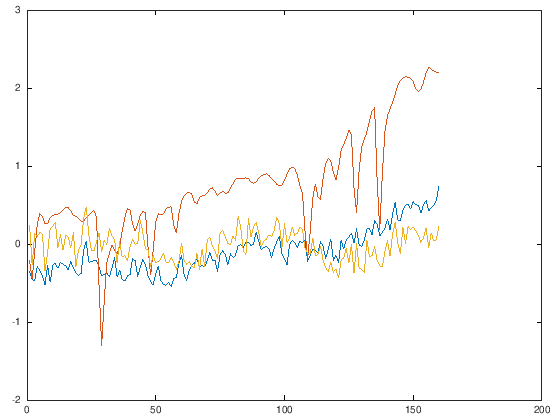

In [8]:
plot([Z,amon])

... better if the figures are inserted in the notebook itself in 'png' format...

In [9]:
%%plot --format png

I'll try to improve the graph

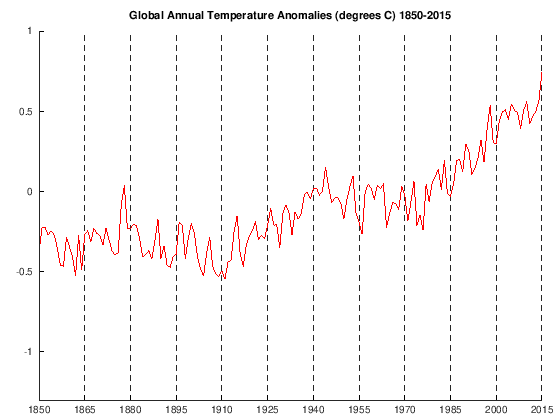

In [10]:
#y=Z(:,1);
dates = gta(:,1);    # first column of gta contains the years
yr = datenum (dates,1,1);
plot(yr, y, 'r')
set (gca(), "xtick", datenum (1850:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
ylim([-1.3, 1])
title('Global Annual Temperature Anomalies (degrees C) 1850-2015')
box off;

## A DHR model for GTA series (first attempt)

I will define a range of AR orders to work with. Since the data are annual, it is better to use long autoregressive orders to avoid identifying noisy trends (I want the pseudo-spectrum of the trend component to be close to a spectral peak very close to the vertical axis, and this is only possible if we use a high order autoregressive polynomial).

In [11]:
rgar = [51:70];

If we do not indicate an a priori model, and also the periodicity of the data is annual `(p=1)`, then the `LDHR` toolbox will try to fit (_whenever possible_) an IRW trend plus an irregular component model.

In [12]:
format long
[VAR0,P0,TVP0,oar0]=autodhr(y,p,[],rgar)
NVR = VAR0(2)/VAR0(1)

VAR0 =

   4.63430546842485e-03   1.62724478233900e-06

P0 = Inf
TVP0 =

   1
   1

oar0 =  63
NVR =    3.51130238053144e-04


`TVP` indicates two unit roots for a component with periodicity `P=Inf`, that is, an IRW trend. VAR contains the estimated variances, `oar` is the order of the AR polinomial used to identify and adjust the model.

Using this model, we filter the series (by Fixed-Interval Smoothing) to obtain the components

In [13]:
[Trend0,season0,cycle0,irreg0]=dhrfilt(y,P0,TVP0,VAR0,p,0,0);

Let's draw them (to make the figure clearer, I will move down the irregular component).

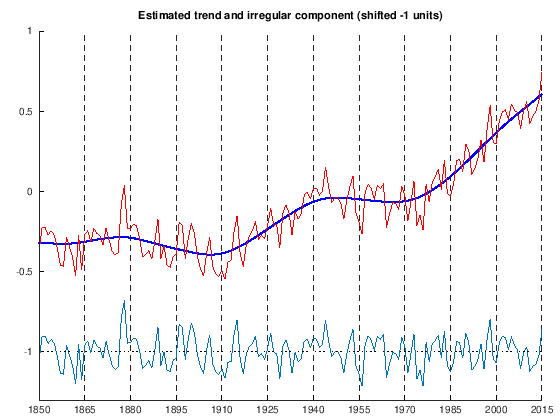

In [14]:
plot(yr, Trend0, '-b', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg0-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated trend and irregular component (shifted -1 units)')
box off;

The trend shows a cyclical behaviour. We can fit an AR polynomial and observe the periodicity associated with the roots of higher modulus and lower frequencies; we then find a cycle of about 63 years.

In [15]:
[ARSPT0, S0, LAGS0, AR0, ROOTS0, NORM0, P0] = aresp(Trend0,rgar,0);

I will show the periodicities of the roots associated to lower frequencies and norms greater than 0.985

In [16]:
[s,i]=sort(P0,'descend');
format bank
n=length(P0);
R=[[1:n]',[P0,NORM0](i(1:n),:)];
R(R(:,3)>.985,:)

ans =

     1.00      Inf     1.04
     2.00   349.29     0.99
     3.00    63.96     1.00
     4.00    21.39     0.99
     8.00     9.13     0.99
    15.00     4.15     0.99
    17.00     3.55     0.99
    20.00     2.88     0.99
    23.00     2.49     1.00
    26.00     2.15     0.99
    27.00     2.04     1.00



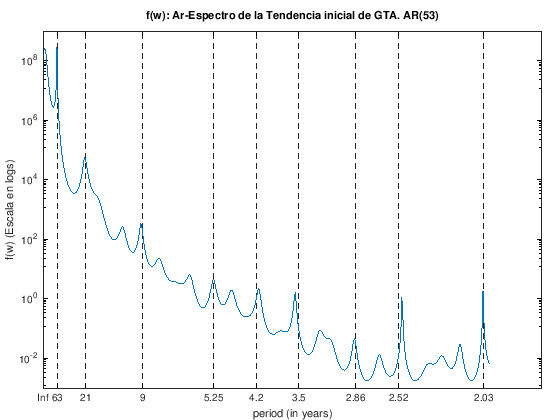

In [17]:
#63./[1:31] % all harmonics
#lcm(21*4, 9*4, 5.25*4)/4
#63./[3,7,12]

[arespt,w]=esptarma(1,AR0);
per=63./[0,1,3,7,12,15,18,22,25,31];   % selected harmonics
semilogy(w,arespt);
set(gca,'XTick',2*pi./per)
set(gca,'XTickLabel',{'Inf','63','21','9','5.25','4.2','3.5','2.86','2.52','2.03'})
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
title(sprintf('f(w): Ar-Espectro de la Tendencia inicial de GTA. AR(%g)',LAGS0))
xlabel('period (in years)')
ylabel('f(w) (Escala en logs)')

From this exploration of the data, it appears that there is a 63 year cycle and several harmonics

Hence, `PaP` will be the "_a priori_" periodicity of our DHR components model

In [18]:
format bank
PaP = 63./[0,1,3,7,12,15,18,22,25,31] 

PaP =

     Inf   63.00   21.00    9.00    5.25    4.20    3.50    2.86    2.52    2.03



Let's try to identify and estimate the parameters of a DHR model 

I will only provide "_a priori_" periodicities `PaP`, the range `rgar` of AR polinomials to explore, the periodicity of the data, i.e. `p=1` (anual data), and the data itself `y`.

In [19]:
format long
[VAR,P,TVP,oar]=autodhr(y,1,[],rgar,PaP)

VAR =

 Columns 1 through 3:

   1.26931676678966e-03   2.50408931012659e-07   4.78911166204942e-06

 Columns 4 through 6:

   7.82938380792177e-06   1.21270710736200e-05   4.95530726824871e-06

 Columns 7 through 9:

   2.15892452121729e-05   2.39767828282597e-06   4.10879954183487e-06

 Columns 10 and 11:

   4.27038920069419e-06   3.89324876392277e-06

P =

 Columns 1 through 4:

                 Inf   63.00000000000000   21.00000000000000    9.00000000000000

 Columns 5 through 8:

    5.25000000000000    4.20000000000000    3.50000000000000    2.86363636363636

 Columns 9 and 10:

    2.52000000000000    2.03225806451613

TVP =

   1   1   1   1   1   1   1   1   1   1
   1   0   0   0   0   0   0   0   0   0

oar =  60


It seems to work! Using the roots of an AR polynomial of order 54, it identifies an IRW trend and three RW cyclic components.

Let's obtain the components by filtering the series:

In [20]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,p,2,0);

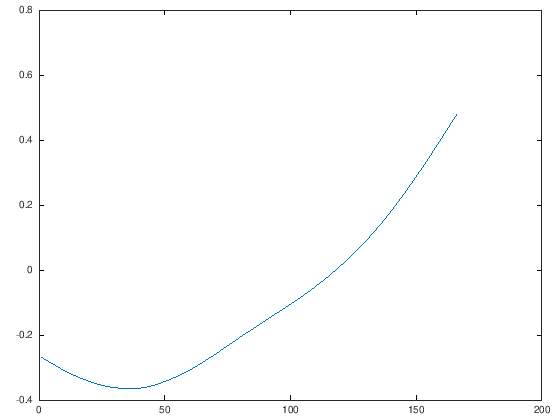

In [21]:
plot(Trend)

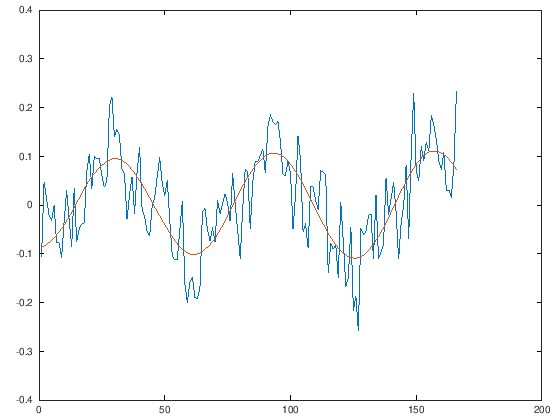

In [22]:
plot([cycle(:,1),cycle(:,2)]) % full cycle and and the harmonic of period 63

As can be seen in the following figure, the Trend-Cycle fits the evolution of the series quite well

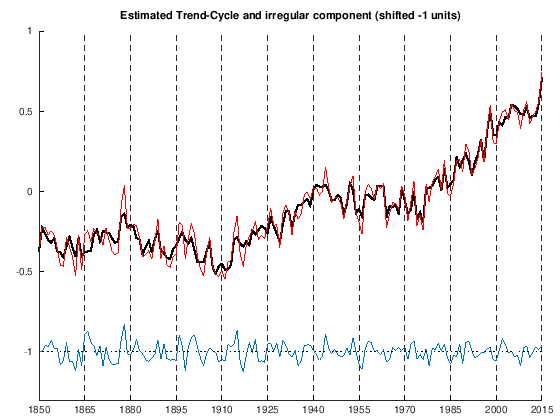

In [23]:
plot(yr, Trend(:,1)+cycle(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated Trend-Cycle and irregular component (shifted -1 units)')
box off;

Although I think it is much more illustrative to plot the long-term Trend on the one hand, and the Cycle on the other.

it seems that the _Cycle_ apparently replicates the behaviour of the [Atlantic Multidecadal Oscillation (AMO)](https://www.psl.noaa.gov/data/timeseries/AMO/) (but I need AMO data to check).

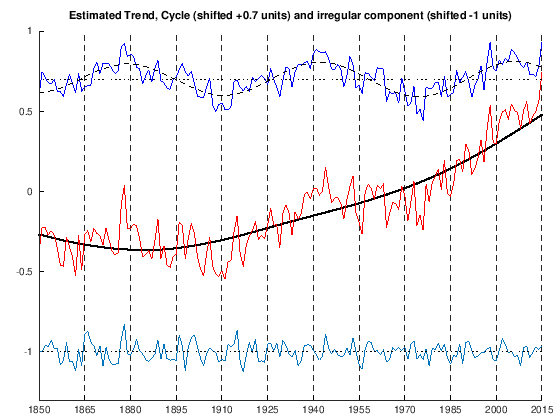

In [24]:
plot(yr, Trend(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
plot(yr, cycle(:,1)+0.7, '-b')
plot(yr, cycle(:,2)+0.7,'--k')
plot(yr, ones(length(y))*.7, ':k')
ylim([-1.3, 1])
title('Estimated Trend, Cycle (shifted +0.7 units) and irregular component (shifted -1 units)')
box off;

## A DHR model for AMO series (first attempt)

Let's try the same with AMO series (Atlantic Multidecadal Oscillation)

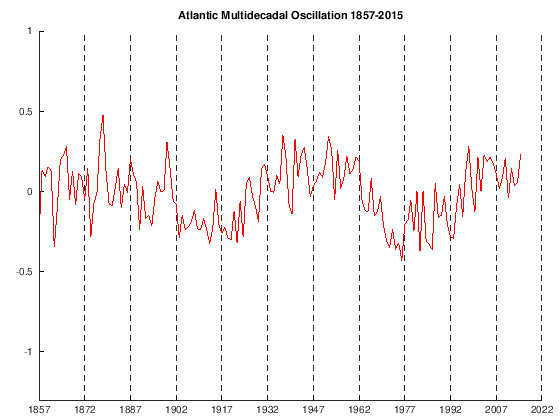

In [25]:
yramon = datenum (dates(7:end),1,1);
plot(yramon, amon(:,1), '-r', "linewidth", 1)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
ylim([-1.3, 1])
title('Atlantic Multidecadal Oscillation 1857-2015')
box off;

In [26]:
[VARamo0,Pamo0,TVPamo0,oaramo0]=autodhr(amon,p,[],rgar)

VARamo0 =

   1.46971946337763e-02   8.12866513236443e-06

Pamo0 = Inf
TVPamo0 =

   1
   1

oaramo0 =  55


This AMO series is linearly detrended data. Nevertheless, DHR identify just only a trend component. When we see it it clear that this IRW trend captures a smooth cycle.

In [27]:
[TrendAMO0,seasonAMO0,cycleAMO0,irregAMO0]=dhrfilt(amon,Pamo0,TVPamo0,VARamo0,p,2);

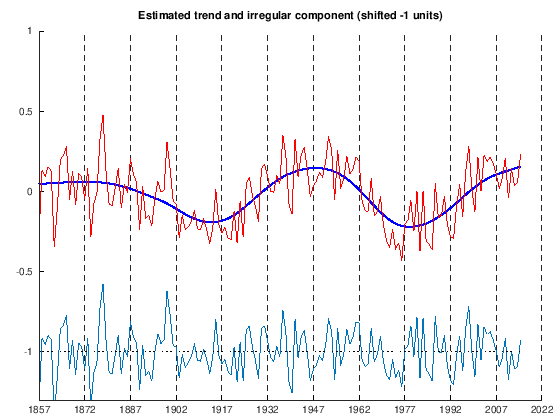

In [28]:
yramon = datenum (dates(7:end),1,1);
plot(yramon, TrendAMO0(:,1)+cycleAMO0(:,1), '-b', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, amon,'-r')
plot(yramon, irregAMO0-1)
plot(yramon, -ones(length(amon)), ':k')
ylim([-1.3, 1])
title('Estimated trend and irregular component (shifted -1 units)')
box off;

### There is something suspicious

It resembles the 63-years cycle GTA component, but is not as regular as the GTA cycle. Mainly at the first part of the sample. Why? I guess both the "Global Temperature" and the Atlantic Ocean must be warmed by the sun and both must be affected by "Radiative Forcing Inputs". So why does the AMO show a different oscillation pattern?

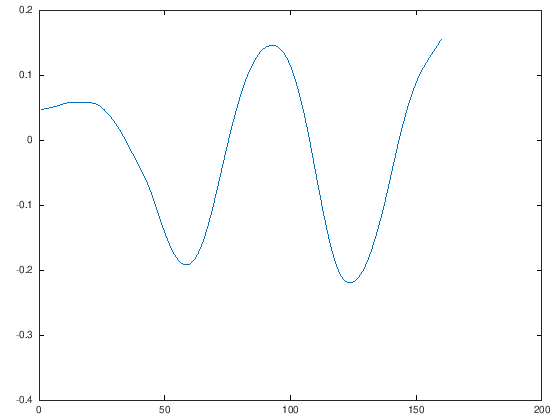

In [29]:
plot(TrendAMO0)

The AMO data has been linearly de-trended, but we have seen that the GTA has a non-linear trend. If we subtract a linear trend from the very first GTA trend, what does it look like?

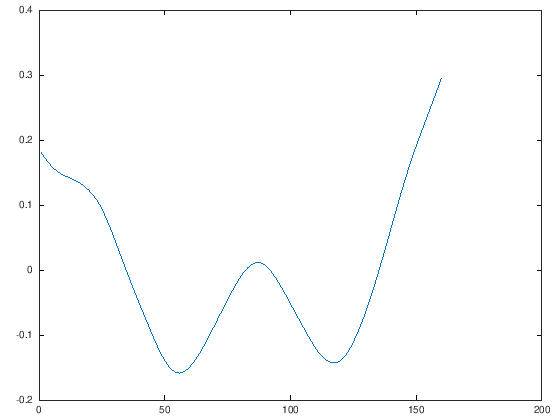

In [30]:
plot(detrend(Trend0(7:end),1))

__My guess:__ the cycles of GTA and AMO looks like no so similar due to the "de-trending procedure" of AMO data

In fact, we can find in the AMO series some harmonics of the 63-year cycle (in particular those associated with the 21- and 9-year cycles).

In [31]:
[ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp(amon,[58:70],0,0);

[s,i]=sort(P,'descend');
format bank
n=length(P);
R=[[1:n]',[P,NORM](i(1:n),:)];
R(R(:,3)>.98,:)

ans =

    1.00     Inf    0.99
    2.00   67.08    1.00
    3.00   30.66    0.98
    4.00   21.08    0.98
    8.00    9.00    1.00
    9.00    7.37    1.00
   11.00    5.99    0.99
   12.00    5.38    0.98
   13.00    5.07    0.98
   16.00    4.05    0.99
   17.00    3.77    0.99
   18.00    3.55    1.00
   19.00    3.32    0.98
   20.00    3.18    0.98
   22.00    2.86    1.00
   24.00    2.65    0.98
   25.00    2.49    0.99
   27.00    2.29    0.99
   28.00    2.20    0.99
   30.00    2.09    0.99
   31.00    2.00    1.00



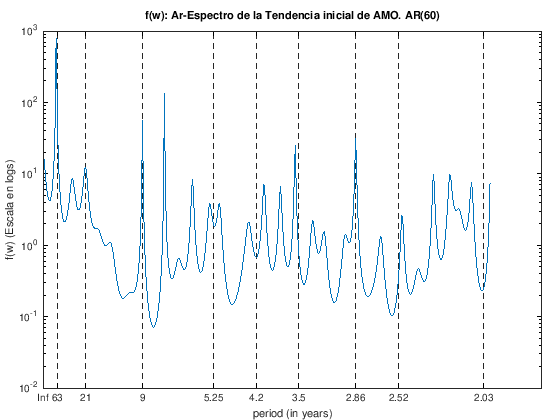

In [32]:
[arespt,w]=esptarma(1,AR);
per=63./[0,1,3,7,12,15,18,22,25,31]; % harmonics selected from the analysis of the GTA series
semilogy(w,arespt);
set(gca,'XTick',2*pi./per)
set(gca,'XTickLabel',{'Inf','63','21','9','5.25','4.2','3.5','2.86','2.52','2.03'})
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
title(sprintf('f(w): Ar-Espectro de la Tendencia inicial de AMO. AR(%g)',LAGS))
xlabel('period (in years)')
ylabel('f(w) (Escala en logs)')

Therefore, if my guess is correct, although the 63-year cycle of the AMO series is very much affected by the de-trending process, the other harmonics should be there. 

So, let's try with a DHR model for AMO that leaves the cycles longer that 21 year in the trend

In [33]:
format bank
PaP = 63./[0,3,7,12,15,18,22,25,31]    # without 63 cycle for AMO

PaP =

     Inf   21.00    9.00    5.25    4.20    3.50    2.86    2.52    2.03



In [34]:
format long
[VAR,P,TVP,oar]=autodhr(amon,p,[],rgar,PaP,[1,1;1,0],1) % I will force the model

VAR =

 Columns 1 through 3:

   1.04051275552021e-02   1.02926472355273e-05   2.89139196790244e-05

 Columns 4 through 6:

   1.30637447469680e-05   2.65744881630802e-05   1.14713530333474e-05

 Columns 7 through 9:

   1.58464040040525e-05   2.26089886395070e-05   2.49232053806980e-05

 Column 10:

   4.35904557868710e-05

P =

 Columns 1 through 4:

                 Inf   21.00000000000000    9.00000000000000    5.25000000000000

 Columns 5 through 8:

    4.20000000000000    3.50000000000000    2.86363636363636    2.52000000000000

 Column 9:

    2.03225806451613

TVP =

   1   1   1   1   1   1   1   1   1
   1   0   0   0   0   0   0   0   0

oar =  58


In [35]:
[TrendAMO,seasonAMO,cycleAMO,irregAMO]=dhrfilt(amon,P,TVP,VAR,p,2,0);

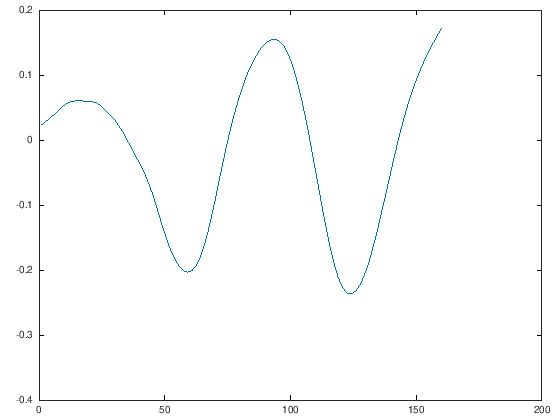

In [36]:
plot(TrendAMO)

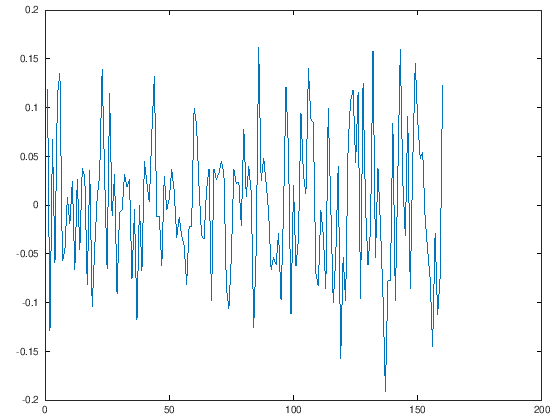

In [37]:
plot(cycleAMO(:,1))

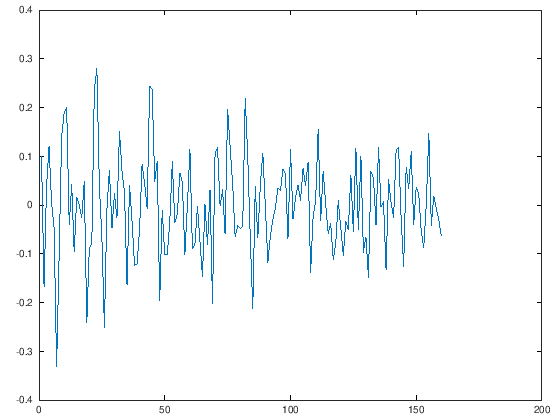

In [38]:
plot(irregAMO)

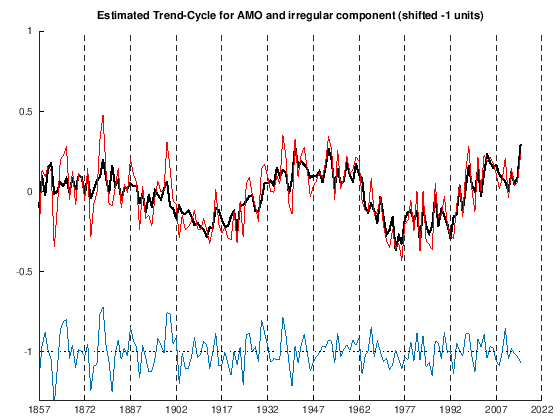

In [39]:
yramon = datenum (dates(7:end),1,1);
plot(yramon, TrendAMO(:,1)+cycleAMO(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, amon,'-r')
plot(yramon, irregAMO-1)
plot(yramon, -ones(length(amon)), ':k')
ylim([-1.3, 1])
title('Estimated Trend-Cycle for AMO and irregular component (shifted -1 units)')
box off;

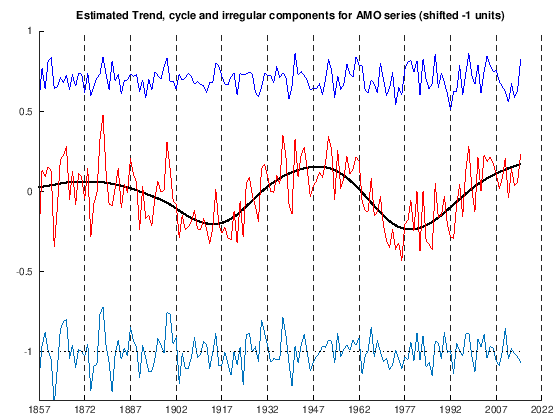

In [40]:
yramon = datenum (dates(7:end),1,1);
plot(yramon, TrendAMO(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, amon,'-r')
plot(yramon, irregAMO-1)
plot(yramon, -ones(length(amon)), ':k')
plot(yramon, cycleAMO(:,1)+0.7, '-b')
ylim([-1.3, 1])
title('Estimated Trend, cycle and irregular components for AMO series (shifted -1 units)')
box off;

The estimated cycles for the GTA and AMO series with 21-year oscillations or less are quite similar.

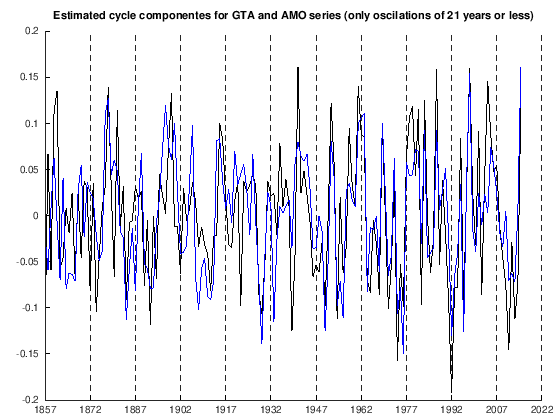

In [41]:
plot(yramon, cycleAMO(:,1), '-k')
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, sum(cycle(7:end,3:end),2),'-b')
title('Estimated cycle componentes for GTA and AMO series (only oscilations of 21 years or less)')
box off;

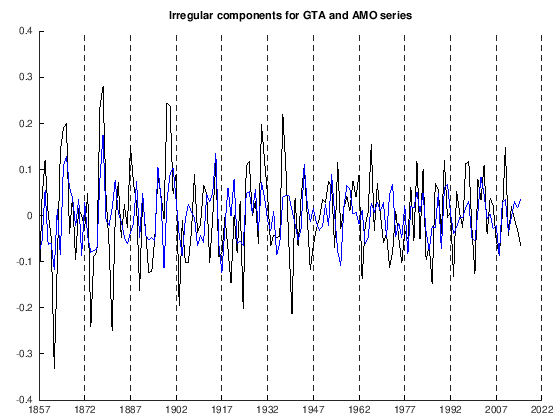

In [42]:
plot(yramon, irregAMO, '-k')
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, irreg(7:end,1),'-b')
title('Irregular components for GTA and AMO series')
box off;

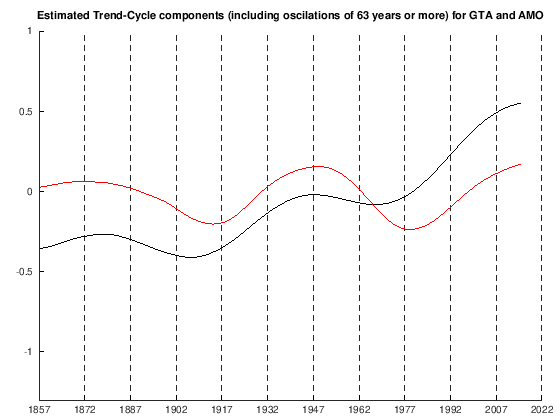

In [43]:
TC=Trend(:,1)+cycle(:,2);
plot(yramon, TC(7:end), '-k')
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, TrendAMO,'-r')
ylim([-1.3, 1])
title('Estimated Trend-Cycle components (including oscilations of 63 years or more) for GTA and AMO')
box off;

If we linearly de-trend the trend-cycle of GTA we get the following graph

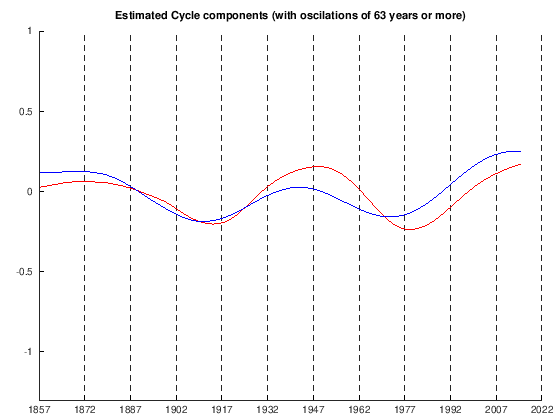

In [44]:
TC=Trend(:,1)+cycle(:,2);
plot(yramon, TrendAMO,'-r')
set (gca(), "xtick", datenum (1857:15:2022,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yramon, (detrend(TC,1))(7:end),'-b')
ylim([-1.3, 1])
title('Estimated Cycle components (with oscilations of 63 years or more)')
box off;

Therefore, perhaps the modelling of the TRF, GTA and AMO will improve and simplify by using the AMO data before the linear de-trending process (I do not know if the original AMO data are available). Otherwise, since the frequency and phase of the AMO cycles are modified,  that modelling is affected.